In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import numpy as np

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_feature_film_series_with_two_entries"

In [4]:
r = requests.get(url)

In [5]:
soup = BeautifulSoup(r.text, 'html.parser')

In [6]:
#mix the soup
m = [item.get_text().split('\n') for item in soup.find_all('ol')]

In [26]:
#Quick function to query the OMDB API
def make_text(text, column):
    try:
        return text[column]
    except:
        return "N/A"

counter = 0

def query_api(title, year):
    
    url = 'http://www.omdbapi.com'
    
    #Handle String years if necessary
    try:
        year = str(int(year))
    except:
        year = 'N/A'
    
    #Populate Params
    params = {'t': title,
           'y': year,
           'apikey': 'f13c3a86'}

    global counter
    counter = counter + 1
    print(counter, title)
    
    #Make the request
    try:
        r = requests.get(url, params=params, timeout=0.6)

        response = r.text
        #print(response)

        json_text = json.loads(response)
    except Exception as e:
        print(e)
        r = 0
    
    try:
        #Populate imdbRating
        '''
        try:
            imdb = json_text['imdbRating']
        except:
            imdb = 'N/A'
        '''
        imdb = make_text(json_text, 'imdbRating')

        #Populate Metascore Rating
        '''
        try:
            metascore = json_text['Metascore']
        except:
            metascore = 'N/A'
        ''' 
        metascore = make_text(json_text, 'Metascore')

        imdb_id = make_text(json_text, 'imdbID')
        #print(imdb, metascore)
    except:
        imdb = 'N/A'
        metascore = 'N/A'
        imdb_id = 'N/A'
    
    return {'imdb': imdb, 'metascore': metascore, 'imdb_id': imdb_id}

In [9]:
#Find all movies
l = [item.text.split('\n') for item in soup.find('div', {'class': 'div-col'}).find_all('li')]

In [10]:
#Remove anything that doesn't have 3 entries
'''
def filterList(item):
    return len(item) == 3
'''

clean_list = list(filter(lambda x: len(x) == 3, l))

In [11]:
#TODO: refactor to work with more than 2 movies
titles = [[{'title':item[1], 'series': item[0]}, {'title':item[2], 'series':item[0]}] for item in clean_list]

In [12]:
#Flatten the list to create a dataframe
df = pd.DataFrame([item for sublist in titles for item in sublist])

In [13]:
#Create a new column by parsing out the date
def return_date(item):
    try:
        return item.split('(')[1].split(')')[0]
    except:
        return np.nan
    
df['date'] = df['title'].apply(lambda x:return_date(x))
df['title_clean'] = df['title'].apply(lambda x: x.split('(')[0])

In [14]:
df

,title,series,date,title_clean
0,00 Schneider – Jagd auf Nihil Baxter (1994),00 Schneider,1994,00 Schneider – Jagd auf Nihil Baxter
1,00 Schneider – Im Wendekreis der Eidechse [de]...,00 Schneider,2013,00 Schneider – Im Wendekreis der Eidechse [de]
2,2 Days in Paris (2007),2 Days in...,2007,2 Days in Paris
3,2 Days in New York (2012),2 Days in...,2012,2 Days in New York
4,8mm (1999),8mm,1999,8mm
...,...,...,...,...
3347,Zulu Dawn (1979) (prequel),Zulu,1979,Zulu Dawn
3348,Zuma (1985),Zuma,1985,Zuma
3349,Anak ni Zuma (1987),Zuma,1987,Anak ni Zuma
3350,Dschungelmädchen für zwei Halunken [de] (1974),Zwei Teufelskerle,1974,Dschungelmädchen für zwei Halunken [de]


In [15]:
#Converte the date column to be and integer
def convert_to_int(item):
    try:
        return float(item)
    except:
        return np.nan

df['date'] = df['date'].apply(lambda x: convert_to_int(x))

In [16]:
#Only keep movies newer than 1990 and let's only worry about the first 100
test_df = df.loc[df['date'] > 1990].copy()

In [80]:
#test_df

In [27]:
#Query the API for each entry and keep building the table
final_df = test_df.merge(test_df.apply(lambda x: pd.Series(query_api(x['title_clean'], x['date'])), axis=1), 
             left_index=True, right_index=True)

t the Elisabethz 2 [fr] 
1073 Men in the City 
1074 Men in the City 2 [de] 
1075 Drachenjungfrau [de] 
1076 Das dunkle Paradies 
1077 Merlin 
1078 Merlin's Apprentice 
1079 Mesrine: Killer Instinct 
1080 Mesrine: Public Enemy Number One 
1081 The Messengers 
1082 Messengers 2: The Scarecrow 
1083 Michael and Madonna 2 
1084 Michael Jackson's This Is It 
1085 Horse Sense 
1086 Jumping Ship 
1087 Mickey's Once Upon a Christmas 
1088 Mickey's Twice Upon a Christmas 
1089 The Girl with the Dragon Tattoo 
1090 The Girl in the Spider's Web 
1091 Mindgame 
1092 Mindgame Trilogy 
1093 Minuscule: Valley of the Lost Ants 
1094 Minuscule 2: Mandibles from Far Away [fr] 
1095 Mirrors 
1096 Mirrors 2 
1097 Miss Congeniality 
1098 Miss Congeniality 2: Armed and Fabulous 
1099 Max V'Morris 
1100 Steirerblut [de] 
1101 Steirerkind [de] 
1102 The Mole 
1103 The Mole 2 
1104 The Moment After 
1105 The Moment After 2: The Awakening 
1106 Mommy 
1107 Mommy 2: Mommy's Day 
1108 Money No Enough 
1109 Money 

In [82]:
# Find the unique names of the series
# series_names = final_df['series'].unique()

In [28]:
#Convert the imdb and metascore columns to int - Could probably clean this up as well

final_df['imdb'] = final_df['imdb'].apply(lambda x: convert_to_int(x))
final_df['metascore'] = final_df['metascore'].apply(lambda x: convert_to_int(x))

In [29]:
final_df.head()

,title,series,date,title_clean,imdb,metascore,imdb_id
0,00 Schneider – Jagd auf Nihil Baxter (1994),00 Schneider,1994.0,00 Schneider – Jagd auf Nihil Baxter,7.1,NaN,tt0109000
1,00 Schneider – Im Wendekreis der Eidechse [de]...,00 Schneider,2013.0,00 Schneider – Im Wendekreis der Eidechse [de],NaN,NaN,N/A
2,2 Days in Paris (2007),2 Days in...,2007.0,2 Days in Paris,6.8,67.0,tt0841044
3,2 Days in New York (2012),2 Days in...,2012.0,2 Days in New York,6.0,61.0,tt1602472
4,8mm (1999),8mm,1999.0,8mm,6.5,19.0,tt0134273


In [30]:
# Drop NA in the imdb column and group_by series, then filter out those series that only have one entry
keep_series = pd.DataFrame(final_df.dropna(subset=['imdb']).groupby('series')['title'].count() == 1).reset_index()

# Build a list of the series to keep (This could probably be combined with the previous cell)
keep_list = list(keep_series.loc[keep_series['title'] == False, 'series'])

# Create the final data frame by keeping only the series that are in the keep list
output = final_df.loc[final_df['series'].isin(keep_list)]

In [31]:
# Create a summary dataframe
summary = output.groupby('series')['imdb'].last() - final_df.groupby('series')['imdb'].first()

<AxesSubplot:ylabel='Density'>

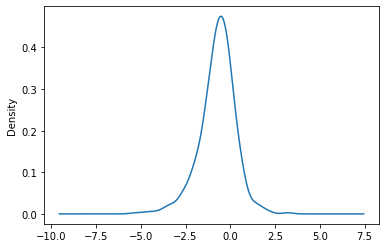

In [32]:
# Plot the review distribution - Maybe I'll do something with this later

summary.plot.kde()

In [33]:
summary.describe()

count    486.000000
mean      -0.713786
std        1.000843
min       -5.300000
25%       -1.200000
50%       -0.600000
75%       -0.100000
max        3.200000
Name: imdb, dtype: float64

In [34]:
#Write output to json format so it's easier to work with in javascript
json_data = output[['title_clean', 'series', 'date', 'imdb', 'imdb_id']].to_json(orient='records')

#Write it to the res directory
with open('../res/movieData.json', 'w') as f:
    f.write(json_data)

In [35]:
summary_data = pd.DataFrame(summary.dropna()).reset_index().to_json(orient='records')
with open('../res/summary.json', 'w') as f:
    f.write(summary_data)